# SVG-VAE

In [1]:
import pyarrow.parquet as pq
import svg_utils
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader
from model import VAEModel
from config import ImageVAEConfig

## Prepare dataset

In [2]:
data_train = pq.read_table('data_train.parquet')
data_train = data_train.to_pandas()

data_test = pq.read_table('data_test.parquet')
data_test = data_test.to_pandas()

data_train.head()

,uni,width,vwidth,sfd,id,binary_fp
0,97,649,1000,"SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...",1,12127215344058962203\n
1,98,560,1000,"SplineSet\n535 284 m 0,0,1\n 535 166 535 166 4...",2,12127215344058962203\n
2,99,712,1000,"SplineSet\n693 125 m 1,0,1\n 686 116 686 116 6...",3,12127215344058962203\n
3,100,710,1000,"SplineSet\n678 378 m 0,0,1\n 678 221 678 221 5...",4,12127215344058962203\n
4,101,613,1000,"SplineSet\n586 0 m 1,0,-1\n 28 0 l 1,1,-1\n 28...",5,12127215344058962203\n


In [3]:
len(data_train)

1971326

Взглянем на сэмпл.

In [4]:
from random import randint
i = 1358568 # randint(0, 1971326)

In [5]:
assert svg_utils._is_valid_glyph(data_train.loc[i])
path = svg_utils._convert_to_path(data_train.loc[i])
assert svg_utils._is_valid_path(path)
data = svg_utils._create_example(path)
data.keys()

dict_keys(['rendered', 'seq_len', 'class', 'binary_fp', 'sequence'])

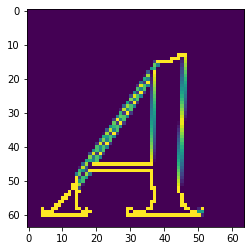

In [6]:
plt.imshow(np.array(data['rendered']).reshape(64, 64))

Подготовим даталоадеры.

In [7]:
data_train.loc[0, :]

uni                                                         97
width                                                      649
vwidth                                                    1000
sfd          SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...
id                                                           1
binary_fp                               12127215344058962203\n
Name: 0, dtype: object

In [18]:
class GlyphDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.cached = self.__getitem__(0)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            example = np.array(svg_utils._create_example(svg_utils._convert_to_path(self.df.loc[idx, :]))['rendered']
                              , dtype=np.float32)
            return torch.FloatTensor(example.reshape(1, 64, 64))
        except Exception as e:
            return self.cached

In [19]:
glyph_train = GlyphDataset(data_train)
glyph_test = GlyphDataset(data_test)

In [20]:
train_loader = DataLoader(glyph_train, batch_size=64)
for X_batch in train_loader:
    print(X_batch.size())
    break

torch.Size([64, 1, 64, 64])


## Model declaration

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
config = ImageVAEConfig()

In [23]:
model = VAEModel(config)

In [24]:
from torchsummary import summary

summary(model, (1, 64, 64), 64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 64, 64]             832
    InstanceNorm2d-2           [64, 32, 64, 64]               0
              ReLU-3           [64, 32, 64, 64]               0
 VisualEncoderCell-4           [64, 32, 64, 64]               0
            Conv2d-5           [64, 32, 32, 32]          25,632
    InstanceNorm2d-6           [64, 32, 32, 32]               0
              ReLU-7           [64, 32, 32, 32]               0
 VisualEncoderCell-8           [64, 32, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          51,264
   InstanceNorm2d-10           [64, 64, 32, 32]               0
             ReLU-11           [64, 64, 32, 32]               0
VisualEncoderCell-12           [64, 64, 32, 32]               0
           Conv2d-13           [64, 64, 16, 16]         102,464
   InstanceNorm2d-14           [64, 64,

## Training

In [25]:
opt = torch.optim.Adam(model.parameters(), eps=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=4, min_lr=0.0001)

In [26]:
import time
from tqdm import tqdm


def train_model(model, opt, scheduler, train_loss, 
                val_accuracy, num_epochs, print_every=5):
    cur_max_acc = None
    for epoch in tqdm(range(num_epochs)):
        print(f'Start epoch {epoch}')
        start_time = time.time()
        model.train()
        epoch_loss = 0
        i = 0
        for X_batch in tqdm(train_loader):
            scores, losses = model(X_batch)
            #print(scores)
            #print(losses)
            loss = losses['training']
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_loss += loss.item()
            if i % print_every == 0:
                print(f'Epoch {epoch}, Batch {i}, loss {loss.item()}')
            i += 1
        cur_val_acc, cur_val_loss = get_accuracy(model, val_batch_gen)
        epoch_loss /= len(train_batch_gen)
        scheduler.step(cur_val_loss)
        
        train_loss.append(epoch_loss)
        val_accuracy.append(cur_val_acc)
        val_loss.append(cur_val_loss)
        
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print('  lr =', scheduler._last_lr[0])
        print("  training loss (in-iteration): \t{:.6f}".format(epoch_loss))
        print("  validate loss (in-iteration): \t{:.6f}".format(cur_val_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(cur_val_acc * 100))
        if cur_max_acc is None or cur_val_acc > cur_max_acc:
            cur_max_acc = cur_val_acc
            torch.save(model.state_dict(), 'models/residual.best4')

In [27]:
train_loss = []
val_accuracy = []
train_model(model, opt, scheduler, train_loss, val_accuracy, 3)



  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/30802 [00:00<?, ?it/s]

Start epoch 0





  0%|          | 1/30802 [00:06<52:11:07,  6.10s/it]

Epoch 0, Batch 0, loss 236389.171875





  0%|          | 2/30802 [00:12<52:02:12,  6.08s/it]


  0%|          | 3/30802 [00:17<50:50:27,  5.94s/it]


  0%|          | 4/30802 [00:23<50:08:19,  5.86s/it]


  0%|          | 5/30802 [00:28<49:22:34,  5.77s/it]


  0%|          | 6/30802 [00:34<48:47:35,  5.70s/it]

Epoch 0, Batch 5, loss -1136604.5





  0%|          | 7/30802 [00:40<48:54:14,  5.72s/it]


  0%|          | 8/30802 [00:46<49:31:40,  5.79s/it]

KeyboardInterrupt: 